--- Simulation Results ---
                      Lot Type         Start           End           Due  \
0                HotLot_7  PHL      0.000000  25533.020200  35308.499267   
1         Regular_Lot_9_9  PRL   2067.666667  28832.346402  49820.441300   
2              HotLot_6_2  PHL  10080.000000  47024.841487  38465.800883   
3              HotLot_3_2  PHL  10080.000000  36919.127282  69378.041767   
4  Engineering_HotLot_1_8  EHL  10560.000000  41759.262685  60522.111717   

      CycleTime  MinProcessingTime  TargetCycleTime      Lateness  OnTime  
0  25533.020200          16115.058     35308.499267  -9775.479066    True  
1  26764.679735          16115.058     47752.774633 -20988.094898    True  
2  36944.841487          16115.058     28385.800883   8559.040604   False  
3  26839.127282          16115.058     59298.041767 -32458.914485    True  
4  31199.262685          16115.058     49962.111717 -18762.849032    True  

Total lots completed: 475
Percentage of lots on time: 80.00

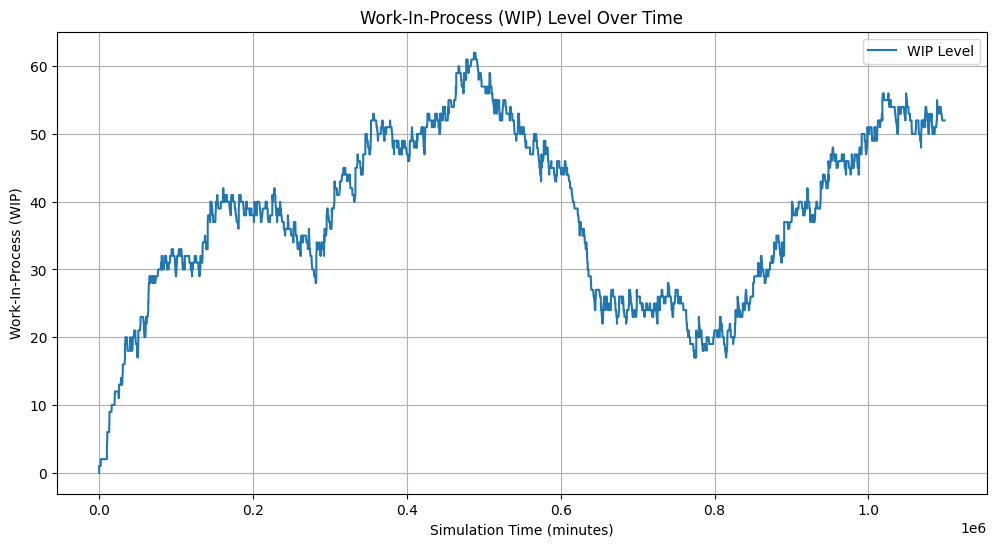

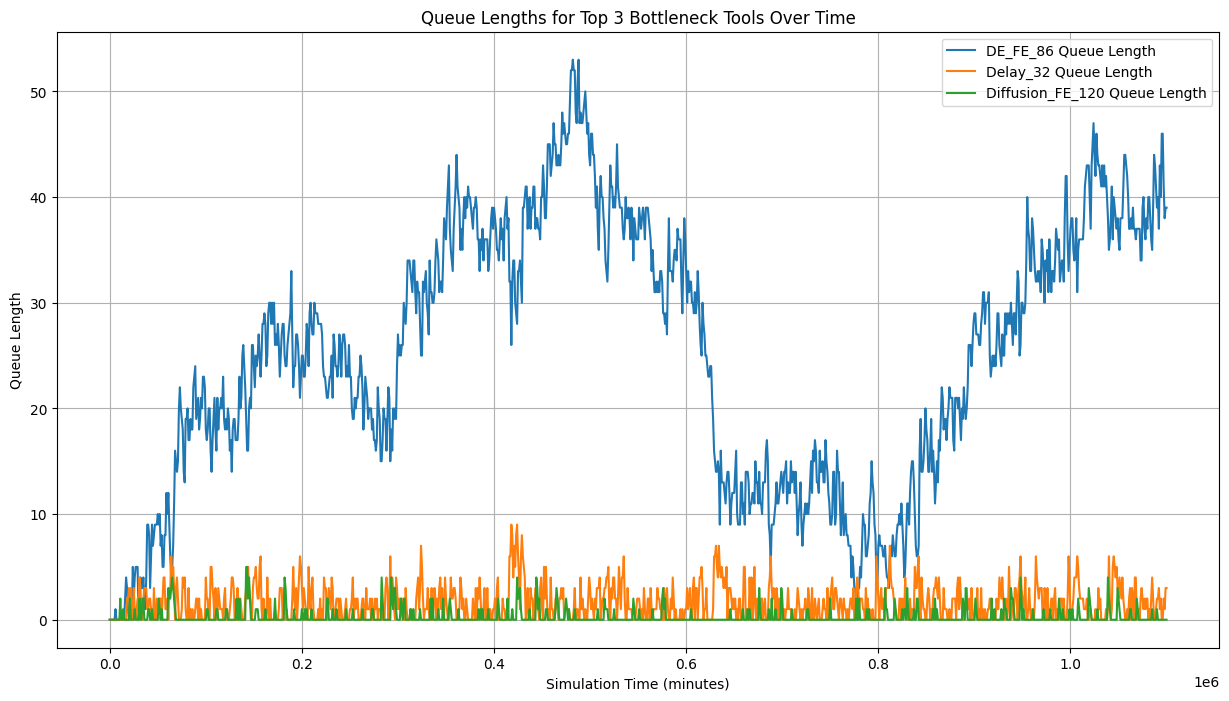

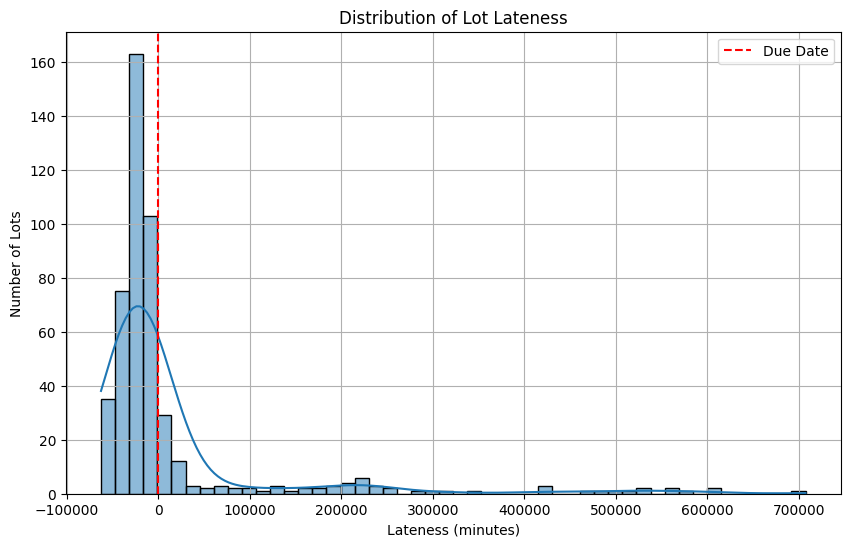

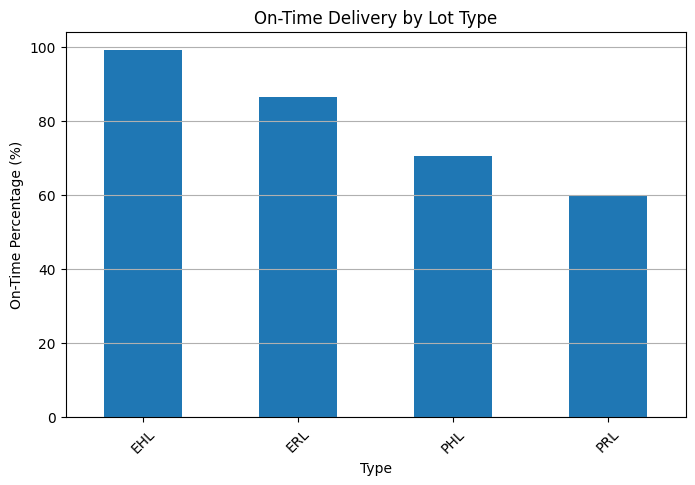

In [1]:
import simpy
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading and Preprocessing ---
# This path assumes the Excel file is available in the same directory or accessible.
# In a real scenario, you'd ensure this path is correct.
file_path = "SMT_2020_Model_Data_-_LVHM_E.xlsx"
lot_df_raw = pd.read_excel(file_path, sheet_name="Lotrelease - variable due dates")
lot_df_eng_raw = pd.read_excel(file_path, sheet_name="Lotrelease - Engineering")
route_df = pd.read_excel(file_path, sheet_name='Route_Product_4')

# Combine and preprocess lot data (performed once)
initial_lot_df = pd.concat([lot_df_raw, lot_df_eng_raw], ignore_index=True)
initial_lot_df['START DATE'] = pd.to_datetime(initial_lot_df['START DATE'])
initial_lot_df['DUE DATE'] = pd.to_datetime(initial_lot_df['DUE DATE'])
base_time = initial_lot_df['START DATE'].min()
initial_lot_df['ReleaseTimeMin'] = (initial_lot_df['START DATE'] - base_time).dt.total_seconds() / 60
initial_lot_df['DueTimeMin'] = (initial_lot_df['DUE DATE'] - base_time).dt.total_seconds() / 60

# Route steps (performed once)
steps = route_df[['STEP', 'TOOLGROUP', 'MEAN']].dropna()
steps['MEAN'] = pd.to_numeric(steps['MEAN'], errors='coerce')

# Calculate the theoretical minimum processing time for a single lot
MIN_PROCESSING_TIME_PER_LOT = steps['MEAN'].sum()

# --- Global Constants and Configuration ---
SIM_TIME = 1100000  # Total simulation time
SETUP_TIME = 10  # Time for tool setup change
LOAD_UNLOAD_TIME = 5  # Fixed time for loading and unloading a lot at a tool
TRANSPORT_TIME_MIN = 5  # Minimum transport time between tool groups
TRANSPORT_TIME_MAX = 10  # Maximum transport time between tool groups

BOTTLENECK_TOOLS = ['ETCH_D', 'LITHO_', 'THIN_F']
BATCH_TOOLS = ['DIFF_']  # Example: Diffusion is a known batching area from paper

# --- Lot Classification ---
def classify_lot_type(lot_id):
    if pd.isna(lot_id):
        return "Unknown"
    lot_str = str(lot_id).upper()
    if "ENG" in lot_str:
        return "EHL" if "HL" in lot_str or "HOT" in lot_str else "ERL"
    elif "HL" in lot_str or "HOT" in lot_str:
        return "PHL"
    else:
        return "PRL"


def balanced_sample(df, n_each=100):
    sampled = []
    for t in ['PRL', 'PHL', 'ERL', 'EHL']:
        subset = df[df['LOT NAME/TYPE'].apply(classify_lot_type) == t]
        if not subset.empty:
            sampled.append(subset.sample(n=min(n_each, len(subset)), random_state=42))
    return pd.concat(sampled)


# --- WIP Tracking & Tool Monitoring Class ---
class SimStats:
    def __init__(self):
        self.current_wip = 0
        self.wip_history = []  # Stores (time, wip_count)
        self.tool_metrics_history = {}  # Stores {tool_name: [(time, queue_len, in_use)]}

    def record_wip(self, env_time):
        self.wip_history.append((env_time, self.current_wip))

    def record_tool_stats(self, env_time, tool_name, queue_len, in_use_count):
        if tool_name not in self.tool_metrics_history:
            self.tool_metrics_history[tool_name] = []
        self.tool_metrics_history[tool_name].append((env_time, queue_len, in_use_count))


# --- Simulation Logic (Refactored to a function to enable multiple runs with config) ---
def run_cr_dispatch_sim_with_config(
        num_lots_per_type_sample,
        initial_lot_dataframe,
        default_tool_capacity,
        bottleneck_tool_capacity,
        tool_downtime_configs,  # New: Dictionary for tool-specific downtime parameters
        processing_time_type  # 'deterministic' or 'variable'
):
    env = simpy.Environment()
    sim_stats = SimStats()

    lot_df_for_run = balanced_sample(initial_lot_dataframe, n_each=num_lots_per_type_sample)
    lot_df_for_run['LotType'] = lot_df_for_run['LOT NAME/TYPE'].apply(classify_lot_type)

    # Use DueTimeMin directly from the dataframe.  No longer overwriting with simplified logic.
    # lot_df_for_run.loc[lot_df_for_run['LotType'].isin(['PHL', 'EHL']), 'DueTimeMin'] = \
    #     lot_df_for_run['ReleaseTimeMin'] + 30000
    # lot_df_for_run.loc[lot_df_for_run['LotType'].isin(['PRL', 'ERL']), 'DueTimeMin'] = \
    #     lot_df_for_run['ReleaseTimeMin'] + 70000

    tool_resources = {}
    tool_capacities_map = {}  # To store actual capacities for bottleneck analysis
    for tool in steps['TOOLGROUP'].unique():
        capacity = bottleneck_tool_capacity if tool in BOTTLENECK_TOOLS else default_tool_capacity
        tool_resources[tool] = simpy.PriorityResource(env, capacity=capacity)
        tool_capacities_map[tool] = capacity  # Store capacity for later analysis

    last_operation = {tool: None for tool in steps['TOOLGROUP'].unique()}

    # --- Tool Downtime Behavior (Now tool-specific) ---
    def tool_downtime_behavior(env, tool_name, tool_resource, downtime_params):
        pm_interval = downtime_params.get('pm_interval')
        pm_duration = downtime_params.get('pm_duration')
        mtbf = downtime_params.get('mtbf')
        mttr = downtime_params.get('mttr')

        if not all([pm_interval, pm_duration, mtbf, mttr]):
            # print(f"Warning: Missing downtime parameters for tool {tool_name}. Skipping downtime process for this tool.")
            return  # Skip downtime process if parameters are incomplete

        while True:
            # Scheduled Maintenance (PM)
            yield env.timeout(pm_interval)
            # print(f"Time {env.now:.2f}: Tool {tool_name} starting PM.")
            with tool_resource.request(priority=-1000) as req:  # High priority to ensure PM happens
                yield req
                yield env.timeout(pm_duration)
            # print(f"Time {env.now:.2f}: Tool {tool_name} PM finished.")

            # Unscheduled Downtime (Breakdown)
            yield env.timeout(random.expovariate(1.0 / mtbf))
            # print(f"Time {env.now:.2f}: Tool {tool_name} broke down.")
            with tool_resource.request(priority=-2000) as req:  # Even higher priority for breakdowns
                yield req
                yield env.timeout(random.expovariate(1.0 / mttr))
            # print(f"Time {env.now:.2f}: Tool {tool_name} repair finished.")

    # Start tool-specific downtime processes
    for tool_name, resource in tool_resources.items():
        # Get specific downtime parameters for this tool. If not explicitly defined,
        # the downtime_behavior function will skip for that tool.
        tool_params = tool_downtime_configs.get(tool_name)
        if tool_params:  # Only start process if parameters are available
            env.process(tool_downtime_behavior(env, tool_name, resource, tool_params))

    lot_records = {}  # To store results for each lot

    def process_lot(env, lot_id, release, due, lot_type, sim_stats_instance):
        # Initial delay until lot release time
        yield env.timeout(max(0, release - env.now))

        sim_stats_instance.current_wip += 1
        sim_stats_instance.record_wip(env.now)

        lot_records[lot_id] = {
            'start': env.now,
            'due': due,
            'type': lot_type,
            'release': release
        }

        min_processing_time = MIN_PROCESSING_TIME_PER_LOT
        lot_records[lot_id]['min_processing_time'] = min_processing_time

        for idx, row in steps.iterrows():
            tool = row['TOOLGROUP']

            # --- TRANSPORTATION TIME (SMT2020: 5-10 minutes between tool groups) ---
            if idx > 0:  # No transport time for the first step
                yield env.timeout(random.uniform(TRANSPORT_TIME_MIN, TRANSPORT_TIME_MAX))

            # --- PROCESSING TIME (SMT2020: Uniform distribution +/- 5% of MEAN) ---
            if processing_time_type == 'deterministic':
                proc_time = row['MEAN']
            else:  # 'variable'
                proc_time = random.uniform(row['MEAN'] * 0.95, row['MEAN'] * 1.05)
                proc_time = max(1, proc_time)  # Ensure processing time is at least 1 min

            # --- LOAD/UNLOAD TIME (SMT2020: Fixed load/unload time added to processing time) ---
            proc_time += LOAD_UNLOAD_TIME

            # --- BATCHING (Conceptual Placeholder for complex implementation) ---
            # Full batching requires lots to wait for each other to form a batch
            # before processing. This is a significant change, potentially involving
            # a custom resource or a separate batching process (e.g., using simpy.Store
            # to collect lots for a batch, then a separate process requests the tool for the batch).
            # If tool in BATCH_TOOLS:
            #   # Logic to wait for other lots, form a batch, and then process the batch
            #   # The resource requested would be for the *batch*, not individual lot,
            #   # and processing time would be for the whole batch.
            # For simplicity, current model processes lots individually.

            # --- CRITICAL RATIO (CR) Dispatching Priority ---
            remaining_proc_time = steps.loc[idx:, 'MEAN'].sum()  # Sum of means for remaining steps
            time_until_due = max(due - env.now, 0.01)  # Avoid division by zero

            cr = remaining_proc_time / time_until_due

            # --- HOT LOT PRIORITY (SMT2020: All hot lots take precedence) ---
            if lot_type in ['PHL', 'EHL']:  # Apply priority boost to both Production and Engineering Hot Lots
                cr *= 0.25  # Lower CR means higher priority in SimPy PriorityResource (smaller number = higher priority)

            priority = cr  # SimPy PriorityResource uses smaller numbers for higher priority

            with tool_resources[tool].request(priority=priority) as req:
                yield req

                # --- SEQUENCE-DEPENDENT SETUP (Conceptual Placeholder) ---
                # This would require a lookup table for setup times between specific
                # operation types/products on the same tool.
                # E.g., `setup_time = get_setup_time(last_operation[tool], row['STEP'])`
                # If `setup_time > 0: yield env.timeout(setup_time)`

                # Current basic setup time if the last operation on the tool changed
                if last_operation[tool] != row['STEP']:
                    yield env.timeout(SETUP_TIME)
                    last_operation[tool] = row['STEP']

                yield env.timeout(proc_time)

        lot_records[lot_id]['end'] = env.now
        sim_stats_instance.current_wip -= 1
        sim_stats_instance.record_wip(env.now)

    def lot_release(env, lots_to_release_df, sim_stats_instance):
        for _, row in lots_to_release_df.iterrows():
            lot_id = row['LOT NAME/TYPE']
            release = row['ReleaseTimeMin']
            # Use the DueTimeMin from the DataFrame directly
            due = row['DueTimeMin']
            lot_type = classify_lot_type(lot_id)
            env.process(process_lot(env, lot_id, release, due, lot_type, sim_stats_instance))
            yield env.timeout(0)  # Allow other processes to run immediately

    def wip_monitor(env, sim_stats_instance, interval=1000):
        while True:
            sim_stats_instance.record_wip(env.now)
            yield env.timeout(interval)

    def tool_stats_monitor(env, tool_resources, sim_stats_instance, interval=1000):
        while True:
            for tool_name, resource in tool_resources.items():
                sim_stats_instance.record_tool_stats(
                    env.now, tool_name, len(resource.queue), resource.count
                )
            yield env.timeout(interval)

    env.process(lot_release(env, lot_df_for_run, sim_stats))
    env.process(wip_monitor(env, sim_stats))
    env.process(tool_stats_monitor(env, tool_resources, sim_stats))
    env.run(until=SIM_TIME)

    # Collect and return results
    rows = []
    for lot_id, rec in lot_records.items():
        if 'end' in rec:  # Only include completed lots
            start = rec['start']
            end = rec['end']
            due = rec['due']
            release = rec['release']

            cycle = end - start
            lateness = end - due
            min_processing_time = rec['min_processing_time']
            target_cycle_time = due - release

            rows.append({
                'Lot': lot_id,
                'Type': rec['type'],
                'Start': start,
                'End': end,
                'Due': due,
                'CycleTime': cycle,
                'MinProcessingTime': min_processing_time,
                'TargetCycleTime': target_cycle_time,
                'Lateness': lateness,
                'OnTime': end <= due
            })

    df_results = pd.DataFrame(rows)
    return df_results, sim_stats.wip_history, sim_stats.tool_metrics_history, tool_capacities_map


def calculate_time_weighted_average_wip(wip_history, sim_end_time):
    if not wip_history:
        return 0

    total_area = 0
    last_time = 0
    last_wip = 0

    filtered_history = [item for item in wip_history if item[0] >= 0]
    if not filtered_history:
        return 0

    # Ensure history starts at time 0 to correctly calculate average from the beginning
    if filtered_history[0][0] != 0:
        filtered_history.insert(0, (0, 0))

    for time, wip in filtered_history:
        if time > last_time:
            total_area += last_wip * (time - last_time)
        last_time = time
        last_wip = wip

    # Add the area for the last segment up to sim_end_time
    total_area += last_wip * (sim_end_time - last_time)

    if sim_end_time > 0:
        return total_area / sim_end_time
    return 0


# --- Bottleneck Analysis Function ---
def analyze_bottlenecks(tool_metrics_history, sim_end_time, tool_capacities_map):
    tool_metrics = {}
    for tool_name, history in tool_metrics_history.items():
        # Add a point at the end of simulation to correctly calculate average over full SIM_TIME
        if history and history[-1][0] < sim_end_time:
            history.append((sim_end_time, history[-1][1], history[-1][2]))  # Use last known state

        total_queue_len_area = 0
        total_in_use_area = 0
        last_time = 0

        # Ensure history starts at time 0 for correct area calculation
        if history and history[0][0] != 0:
            history.insert(0, (0, 0, 0))  # (time, queue_len, in_use)

        for time, queue_len, in_use_count in history:
            if time > last_time:
                # Area = value * duration
                total_queue_len_area += (queue_len * (time - last_time))
                total_in_use_area += (in_use_count * (time - last_time))
            last_time = time

        avg_queue_length = total_queue_len_area / sim_end_time if sim_end_time > 0 else 0
        avg_utilization = (total_in_use_area / (tool_capacities_map.get(tool_name, 1) * sim_end_time)) if (tool_capacities_map.get(tool_name, 1) * sim_end_time) > 0 else 0


        tool_metrics[tool_name] = {
            'avg_queue_length': avg_queue_length,
            'avg_utilization': avg_utilization
        }

    # Sort tools by average queue length to identify potential bottlenecks
    sorted_tools = sorted(tool_metrics.items(), key=lambda item: item[1]['avg_queue_length'], reverse=True)
    return sorted_tools

# --- Main Simulation Execution ---
if __name__ == "__main__":
    # Example downtime configuration (these values would typically come from PM.csv and Breakdown.csv)
    # For now, using illustrative values for two tools. You'd expand this based on the actual data.
    tool_downtime_configs = {
        'ETCH_D': {'pm_interval': 10000, 'pm_duration': 60, 'mtbf': 5000, 'mttr': 30},
        'LITHO_': {'pm_interval': 8000, 'pm_duration': 50, 'mtbf': 4000, 'mttr': 25},
        # Add more tools as needed based on your PM.csv and Breakdown.csv data
    }

    results_df, wip_history, tool_metrics_history, tool_capacities_map = run_cr_dispatch_sim_with_config(
        num_lots_per_type_sample=500,  # Sample 500 lots of each type for a more robust simulation
        initial_lot_dataframe=initial_lot_df.copy(),
        default_tool_capacity=1,
        bottleneck_tool_capacity=1,
        tool_downtime_configs=tool_downtime_configs,
        processing_time_type='variable' # 'deterministic' or 'variable'
    )

    print("--- Simulation Results ---")
    print(results_df.head())
    print(f"\nTotal lots completed: {len(results_df)}")
    print(f"Percentage of lots on time: {results_df['OnTime'].mean() * 100:.2f}%")
    print(f"Average Lateness (minutes): {results_df['Lateness'].mean():.2f}")
    print(f"Max Lateness (minutes): {results_df['Lateness'].max():.2f}")

    # Calculate average WIP
    avg_wip = calculate_time_weighted_average_wip(wip_history, SIM_TIME)
    print(f"\nAverage Work-In-Process (WIP): {avg_wip:.2f} lots")

    # Analyze and print bottleneck tools
    print("\n--- Bottleneck Analysis (Sorted by Average Queue Length) ---")
    bottleneck_analysis_results = analyze_bottlenecks(tool_metrics_history, SIM_TIME, tool_capacities_map)
    for tool, metrics in bottleneck_analysis_results:
        print(f"Tool: {tool}, Avg Queue Length: {metrics['avg_queue_length']:.2f}, Avg Utilization: {metrics['avg_utilization'] * 100:.2f}%")

    # --- Plotting WIP over Time ---
    wip_times = [item[0] for item in wip_history]
    wip_counts = [item[1] for item in wip_history]

    plt.figure(figsize=(12, 6))
    plt.plot(wip_times, wip_counts, label='WIP Level')
    plt.xlabel('Simulation Time (minutes)')
    plt.ylabel('Work-In-Process (WIP)')
    plt.title('Work-In-Process (WIP) Level Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plotting Tool Queue Lengths over Time for Bottlenecks ---
    # Select top N tools from bottleneck analysis for detailed plotting
    N_TOP_BOTTLENECKS = 3
    top_bottlenecks = [tool for tool, metrics in bottleneck_analysis_results[:N_TOP_BOTTLENECKS]]

    if top_bottlenecks:
        plt.figure(figsize=(15, 8))
        for tool_name in top_bottlenecks:
            if tool_name in tool_metrics_history:
                times = [item[0] for item in tool_metrics_history[tool_name]]
                queue_lens = [item[1] for item in tool_metrics_history[tool_name]]
                plt.plot(times, queue_lens, label=f'{tool_name} Queue Length')
        plt.xlabel('Simulation Time (minutes)')
        plt.ylabel('Queue Length')
        plt.title(f'Queue Lengths for Top {N_TOP_BOTTLENECKS} Bottleneck Tools Over Time')
        plt.grid(True)
        plt.legend()
        plt.show()

    # --- Plotting Lateness Distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['Lateness'], bins=50, kde=True)
    plt.xlabel('Lateness (minutes)')
    plt.ylabel('Number of Lots')
    plt.title('Distribution of Lot Lateness')
    plt.axvline(x=0, color='r', linestyle='--', label='Due Date')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting On-Time Delivery by Lot Type ---
    on_time_by_type = results_df.groupby('Type')['OnTime'].mean() * 100
    plt.figure(figsize=(8, 5))
    on_time_by_type.plot(kind='bar')
    plt.ylabel('On-Time Percentage (%)')
    plt.title('On-Time Delivery by Lot Type')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()